<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###To Do:
 - Figure out the mystery of missing image number 1010
 - Get a DataLoader working


###Fix at the end:
 - Size images back up
 - Get images to work even if they’re not square


 ----------------------------------------------


In [0]:
# !pip install torch 
# !pip install torchvision
# !pip install tqdm
# !pip install kaggle

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import os

assert torch.cuda.is_available()

In [0]:
os.environ['KAGGLE_USERNAME'] = 'porter7678'
if not 'KAGGLE_KEY' in os.environ:
  os.environ['KAGGLE_KEY'] = input()

In [4]:
# ~70 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')

100% 2.07G/2.08G [00:50<00:00, 39.2MB/s]
100% 2.08G/2.08G [00:51<00:00, 43.7MB/s]


In [0]:
############ - DATATSET README - ################################################################
# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset,
#       the first column is the ID of the caption which is "image address # caption number"
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
# Flickr_8k.trainImages.txt - The list of training images used in our experiments
# Flickr_8k.devImages.txt - The list of development/validation images used in our experiments
# Flickr_8k.testImages.txt - The list of test images used in our experiments
#################################################################################################
# 8091 images

In [0]:
def show_imgs(x, new_fig=True):
    '''
    Displays the image contained in a tensor.

    Arguments:
        x ((c,m,n) tensor): The image to be shown
    '''
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [126]:
# Create list of images to move to validation folder
valid_img_names = []
file_names = ['Flickr8k_text/Flickr_8k.devImages.txt', 'Flickr8k_text/Flickr_8k.testImages.txt']
for file_name in file_names:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            valid_img_names.append(line.strip())

# Move validation images to validation folder
for file_name in valid_img_names:
    os.replace('Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/' + file_name, 'Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid/' + file_name)

FileNotFoundError: ignored

In [0]:
class ImageCaptionDataset(Dataset):
    '''
    Dataset class containing images and captions

    Attributes:
        image_folder (ImageFolder Dataset): Images to be captioned (data)
        caption_folder (Dataset): Captions associated with images for validation (labels)
    '''
    def __init__(self, train=True):
        img_size = 128

        # Initialize with training images or validation images depending on input
        folder_prefix = 'Train' if train else 'Valid'
        folder_path = 'Flickr8k_Dataset/' + folder_prefix + '_Images'
        self.image_folder = datasets.ImageFolder(root=folder_path,
                                                transform=transforms.Compose([
                                                    transforms.Resize(img_size),
                                                    #transforms.CenterCrop(img_size),  # This is the line that is making images square
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                ]))
        

        # NOTE: There is a chance I need to find a way to stick this caption attribute in a Dataset class for the dataloader to work.
        train_img_captions = []
        valid_img_captions = []
        curr_img_captions = []

        with open('Flickr8k_text/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            line = line.strip().split('\t')
            curr_img_captions.append(line[1])

            # Each image has five captions, so start a new caption list each 5 iterations
            if i % 5 == 4:
                img_name = line[0][:-2]
                if img_name in valid_img_names:
                    valid_img_captions.append((img_name, curr_img_captions))
                else:
                    train_img_captions.append((img_name, curr_img_captions))
                curr_img_captions = []


        self.caption_folder = train_img_captions if train else valid_img_captions

    
    def __getitem__(self, index):
        img = self.image_folder[index]
        captions = self.caption_folder[index]
        return img[0], captions[1]
        

    def __len__(self):
        return 49


1009 ['As the brown dog looks the other way , a large black and white dog plays with a smaller black dog .', 'Orange , brown and white and brown dogs on grass .', 'Three dogs playing and laying on the grass .', 'Three dogs playing in a yard together .', 'three dogs play together .']
1010 ['people waiting for the subway', 'Some people looking out windows in a large building .', 'Three people are waiting on a train platform .', 'Three people standing at a station .', 'two woman and one man standing near train tracks .']
1011 ['A child in a black wetsuit is in the waves on a surfboard .', 'A kid on a surfboard riding a small wave .', 'A small boy in black is surfing .', 'A young boy in a black wetsuit surfs in the water .', 'A young surfer rides a wave .']
1012 ['Two gray dogs run together over the green grass .', 'Two gray , speckled dogs running down grass hill , trees in background .', 'Two grey dogs running in green grass .', 'Two identical dogs bound across a lush green meadow .', 'T

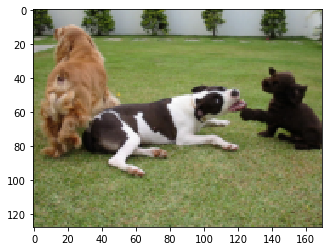

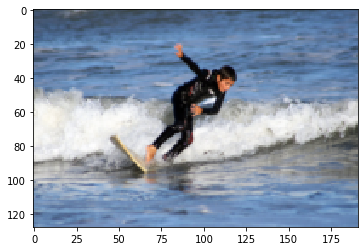

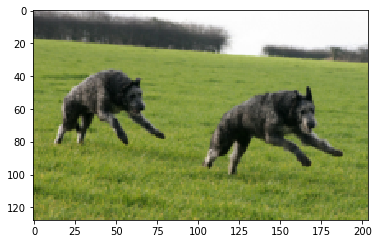

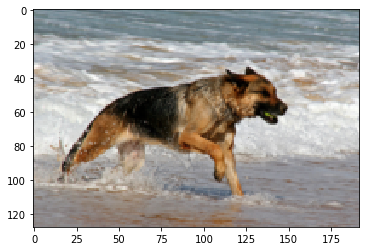

In [124]:
dataset = ImageCaptionDataset(train=True)
# x, _ = dataset.image_folder[0]
# show_imgs(x)

# MISSING IMG No. 1010!

randos = [1009, 1010, 1011, 1012]

for rand in randos:
    x, y = dataset[rand]
    show_imgs(x)
    print(rand, y)